# CMS Anomaly Detection

In this experiment we build a network that consists of subnetworks linked by a logistic regression.
Each subnetwork is built on features that correspond to one of the following channels:
- muons
- photons
- particle flows (PF)
- particles from calorimiter (calo)

The ultimate goal is to estimate probability of anomalies occuring in each individual channel by learning to predict global probabilities. This is done by training this network on labels of global anomalies (i.e. is anomaly present somewhere) and then defining output of each subnetwork as score for anomaly in its channel.

The justification of this approach is following.

Consider a set of channels $\mathcal{C}$ listed above and set of anomalies $\mathcal{A}$.
Each anomaly $A \in \mathcal{A}$ corresponds to a subset of channels $C \subseteq \mathcal{C}$ where this anomaly occurs. The main assumptions:
1. each possible anomaly can be detected by at least one subnetwork;
2. any classifier build on features from channels $\bar{C} = \mathcal{C} \setminus C$ can not detect anomaly $A$, e.g. anomaly in the photon channel does not change behaviour of muons.
Thus, from the prospective of detecting anomaly $A$ score of any classifier built on $\bar{C}$ is no more than an independent random variable.

The network and its loss function are defined in the way that the given anomaly $A$ loss is the lower the more subnetworks report anomaly. Since subnetworks from $\bar{C}$ in principle have no predictive power for $A$, average loss reaches its minimum close to the situation when for each kind of anomaly $A$ affecting channels $C$ subnetworks from $C$ report anomaly and the rest report no abnormalities in their channels, i.e. each subnetwork reports presence of anomaly in its channel, which is exactly the goal of this experiment.

However, this ideal result occur only when anomalies have the same weight, but due to the nature of the loss function: if at least one network reports anomaly, which is always true by assumption 1, another subnetwrok can change the score torwards anomaly only slightly. Thus any considerable bias of subnetwork torwards anomalies implies much higher losses under 'everything is good' sutiation than gain from unrelated anomalies:

$$\mathbb{E}[ \mathcal{L}(\mathrm{subnetwork} + \mathrm{bias}) - \mathcal{L}(\mathrm{subnetwork}) \mid \mathrm{no\;anomalies}] \gg \mathbb{E}[ \mathcal{L}(\mathrm{subnetwork}) - \mathcal{L}(\mathrm{subnetwork} + \mathrm{bias}) \mid \mathrm{unrelated\;anomaly}]$$

## Prepearing data

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

import re

DATA_PATH = 'merged.pickle'

The input files contains preselected features from CMS 2010B open data.
The features were generated from original root in following way:

1. There were selected 3 streams:
  - MiniBias,
  - muons,
  - photons.
2. In each stream 4 "channels" were selected:
  - muons
  - photons
  - PF (particle flows)
  - calo (calorimiter)
3. For each channel from each event  5 quantile particles were selected with redards to thier momentum: quantile $q_i$ corresponds to particle with index closest to $\frac{i}{5}N$, i.e. $q_5$ corresponds to the particle with maximal momentum.
4. Each particle is described by its physical properties: $\eta, \phi, p_T, f_x, f_y, f_z, m$
5. Physical features were aggragated by lumisections, producing:
  - 1, 25, 50, 75, 99 percentiles
  - mean and std
  
As the result each lumisection is described by percentiles, means and stds of distributions of physical features of particles of particular quantiles within particular channel within particular stream.

Some additional features were added like total momentum of all particles of particular channel within event

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

with open('subsystem_labels.pickled', 'r') as f:
    sub_labels = pickle.load(f)

labels = np.load('labels.npy')

In [3]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [5]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons'].get_values()),
    data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [6]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]
sub_labels = sub_labels.iloc[nonempty]

In [7]:
plt.figure(figsize=(8, 8))

plt.hist(
    [lumi[labels == 1.0], lumi[labels == 0.0]],
    label=['Good lumisections', 'Bad lumisections'],
    color=['green', 'red'],
    bins=20,
    histtype='step'
)

plt.legend(loc='upper right')

plt.title('Luminosity distribution')
plt.xlabel('Luminosity')
plt.ylabel('number of lumisections')
plt.show()

<IPython.core.display.Javascript object>

In [8]:
lumi_bad = np.sum(lumi[labels == 0.0])
lumi_good = np.sum(lumi[labels == 1.0])

### By normalizing weights we implicitly define equal probabilities for each class
weights = lumi / np.where(labels == 1.0, lumi_good, lumi_bad)

## Grouping features

Feature set has its own intrisic hierarchy. It can be easily seen from their names:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [9]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [10]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

### Selecting particles' features:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [11]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [12]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


### Selecting features that belong to a particle type:
> `<stream>_<particle type>_<physical feature>_<feature quantile>`

In [13]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [14]:
for level in particle_type_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [15]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


The features above are components of momentum of particles of particular type (channel) within event.

### Selecting features specific to events:
> `<stream>_<physical feature>_<feature quantile>`

In [16]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [17]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [18]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


Which are instant luminosity of each event.

In [19]:
rest

['minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights']

### And finally features specific to lumisection itself:
> `<stream>_<physical feature>_<feature quantile>`

In [20]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [21]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias photons
nEvents nonZeroWeights


Number of events and fration of non-zero features for lumisection (all NA's are replaced with zeros).

In [22]:
rest

[]

In [23]:
from collections import defaultdict

def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = path[:level]
        gd[gk].append(k)
    
    return gd

In [24]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

All features are grouped by stream-channel.

In [25]:
grouped = group(feature_hierarchy, level=2)

In [26]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[((u'muons', u'photons'), 231),
 ((u'minibias', u'PF'), 126),
 ((u'photons', u'photons'), 231),
 ((u'minibias', u'calo'), 266),
 ((u'muons', u'muons'), 266),
 ((u'photons', u'muons'), 266),
 ((u'minibias', 'allChannels'), 7),
 ((u'photons', u'calo'), 266),
 ((u'photons', u'PF'), 126),
 ((u'muons', u'PF'), 126),
 ((u'minibias', u'photons'), 231),
 ((u'muons', 'allChannels'), 7),
 ((u'photons', 'allChannels'), 7),
 ((u'minibias', u'muons'), 266),
 ((u'muons', u'calo'), 266)]

For this experiment only the following groups are used:
- muons from muon stream
- photons from photon stream
- Particle Flows from minibias stream
- calo particles from minibias stream

In [27]:
channels_features = dict()

for k in [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]:
    channels_features[k[1]] = grouped[k]

In [28]:
channels_features['muons'].append('_instantLumi_muons')
channels_features['photons'].append('_instantLumi_photons')

In [29]:
[ (g, len(fs)) for g, fs in channels_features.items() ]

[('muons', 267), ('photons', 232), ('PF', 126), ('calo', 266)]

## Building netwrok

In [30]:
%env THEANO_FLAGS='device=gpu0', 'floatX=float32'

import theano
import theano.tensor as T

from lasagne import *

env: THEANO_FLAGS='device=gpu0', 'floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [31]:
### For simplicity each feature group is put into its own shared variable.
shareds = {}

for k in channels_features:
    features = channels_features[k]

    shareds[k] = theano.shared(
        data[features].get_values().astype('float32'),
        name = 'X %s' % k
    )

In [32]:
labels_shared = theano.shared(labels.astype('float32'), 'labels')
weights_shared = theano.shared(weights.astype('float32'), 'weights')

In [33]:
batch_indx = T.ivector('batch indx')

For each feature group we build a dense neural network.
On the one hand, a network should be capable of capturing non-trivial anomalies,
on the other hand a number of training samples is small. It is the reason why heavy dropout is applied for each layer.

Nevertheless, we should expect low bias due to dropout, since it is believed that not all features should interact
directly within one unit. For example, it is reasonable that momentum features do not mix with angular ones within one unit. Thus structure of weights should be sparse, which is one of the effects of the dropout regularization.

In [34]:
def build_network(shared, batch_indx, num_units = (50, 10), n_dropout=2):
    n_features = shared.get_value().shape[1]
    X_batch = shared[batch_indx]

    input_layer = layers.InputLayer(shape=(None, n_features), input_var=X_batch)
    net = input_layer
    
    net = layers.DropoutLayer(net, p=0.1, rescale=False)
    
    for i, n in enumerate(num_units):
        net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.sigmoid)
        if i < n_dropout:
            net = layers.DropoutLayer(net, p=0.1, rescale=True)
    
    net = layers.DenseLayer(net, num_units=1, nonlinearity=nonlinearities.sigmoid)
    
    det_prediction = T.flatten(layers.get_output(net, deterministic=True))
    train_prediction = T.flatten(layers.get_output(net, deterministic=False))
    
    return net, det_prediction, train_prediction

In [35]:
networks = {}
det_predictions = {}
train_predictions = {}

for k in shareds:
    shared = shareds[k]

    net, det_prediction, train_prediction = build_network(shared, batch_indx, num_units=(150, 50, 20))
    
    det_predictions[k] = det_prediction
    train_predictions[k] = train_prediction

    networks[k] = net

In [36]:
get_get_predictions = {}
get_stochastic_predictions = {}

for k in det_predictions:
    get_get_predictions[k] = theano.function([batch_indx], det_predictions[k])
    get_stochastic_predictions[k] = theano.function([batch_indx], train_predictions[k])

In [37]:
xs = np.linspace(0, 4)

ys = np.exp(xs - 4)

plt.figure()
plt.plot(xs, ys)
plt.xlabel('sum of subnetworks activations')
plt.ylabel('response of the whole network')
plt.show()

<IPython.core.display.Javascript object>

In [38]:
def fuzzy_and(args):
    s = reduce(lambda a, b: a + b, args)
    return T.exp(s - 4.0)

train_global_prediction = fuzzy_and(train_predictions.values())

det_global_prediction = fuzzy_and(det_predictions.values())

In [39]:
labels_batch = labels_shared[batch_indx]
weights_batch = weights_shared[batch_indx]

Regularization in this network has a slightly different structure in comparison to traditional ones.
Since our ultimate goal is to learn how to predict anomalies in different channels independently, one subnetwork may not get more predictive power by cost of another even if the channel of the second network has lower predictive power.

Taking maximum of regularization penalties from each network ensures that one network can not lower its penalty by lowering predictive power of other (thus decreasing its penalty).

In [40]:
reg = reduce(lambda a, b: T.maximum(a, b), [
    regularization.regularize_network_params(networks[k], penalty=regularization.l2)
    for k in networks
])

In [41]:
c_reg = T.fscalar('c reg')

In [42]:
log_losses = -((1 - labels_batch) * T.log(1 - train_global_prediction) + labels_batch * T.log(train_global_prediction))

pure_loss = T.sum(weights_batch * log_losses) / T.sum(weights_batch)

loss = pure_loss +  c_reg * reg

In [43]:
params = reduce(lambda a, b: a + b, [
        layers.get_all_params(net)
        for net in networks.values()
])

learning_rate = T.fscalar('learning rate')
upd = updates.adadelta(loss, params, learning_rate = learning_rate)

In [44]:
train = theano.function([batch_indx, c_reg, learning_rate], [pure_loss, loss], updates=upd)
get_loss = theano.function([batch_indx], pure_loss)

get_prediction = theano.function([batch_indx], det_global_prediction)
get_train_prediction = theano.function([batch_indx], train_global_prediction)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
indx_train, indx_test = train_test_split(np.arange(data.shape[0], dtype='int32'), stratify=labels, test_size=0.1)

In [47]:
def batch_stream(X, batch_size=32):
    indx = np.random.permutation(X.shape[0])
    n_batches = X.shape[0] / batch_size

    for i in xrange(n_batches):
        batch_indx = indx[(i * batch_size):(i * batch_size + batch_size)]
        yield X[batch_indx]

In [48]:
from crayimage.utils import NNWatcher

<IPython.core.display.Javascript object>


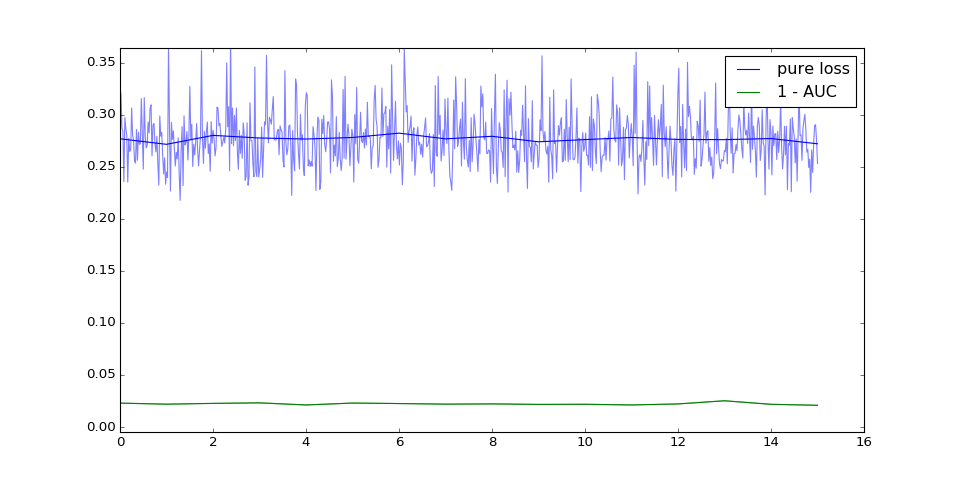

In [49]:
watcher = NNWatcher(labels=('pure loss', '1 - AUC'), colors=('blue', 'green'))

In [98]:
from sklearn.metrics import roc_auc_score
n_epoches = 16
batch_size = 512
n_batches = indx_train.shape[0] / batch_size

pure_losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
validation_loss = np.zeros(shape=(n_epoches, 1), dtype='float32')

lr = np.float32(1.0)
c_reg = np.float32(1.0e-5)

for epoch in xrange(n_epoches):
    for i, idx in enumerate(batch_stream(indx_train, batch_size=batch_size)):
        pure_losses[epoch, i], _ = train(idx, c_reg, lr)
    
    mean_predictions = np.mean(np.array([
        get_train_prediction(indx_train)
        for _ in range(16)
    ]), axis=0)

    validation_loss[epoch] = 1 - roc_auc_score(
        labels[indx_train],
        mean_predictions,
        sample_weight=weights[indx_train]
    )
    
    watcher.draw(
        pure_losses[:(epoch + 1)],
        validation_loss[:(epoch + 1)]
    )

<IPython.core.display.Javascript object>


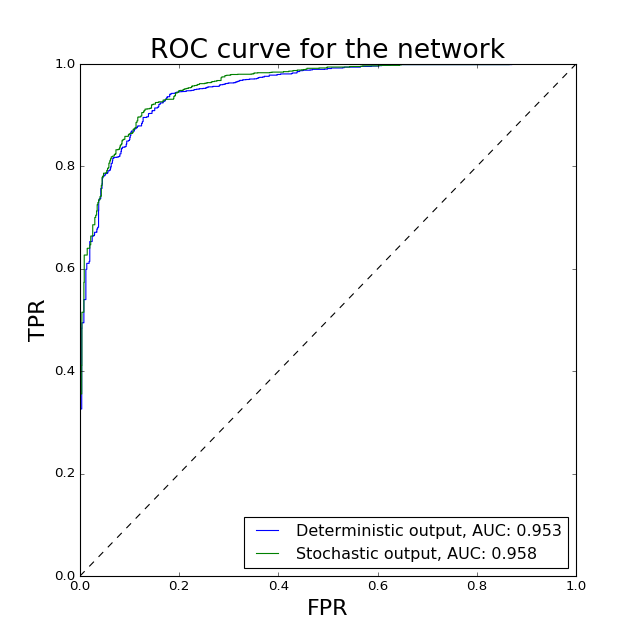

In [64]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

common_proba = get_prediction(indx_test)

mean_proba = np.mean(np.array([
        get_train_prediction(indx_test)
        for _ in range(64)
]), axis=0)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

fpr, tpr, _ = roc_curve(labels[indx_test], common_proba, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Deterministic output, AUC: %.3lf' % auc_score)

fpr, tpr, _ = roc_curve(labels[indx_test], mean_proba, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Stochastic output, AUC: %.3lf' % auc_score)

plt.legend(loc='lower right')
plt.title('ROC curve for the network', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

In [65]:
probas = {}

for k in ['muons', 'photons', 'PF', 'calo']:
    feautures = channels_features[k]
    probas[k] = get_get_predictions[k](indx_test)

## Predicting anomalies in individual channels.

To make a rough estimation of how much data from a channel can be saved, outputs of subnewtorks are plotted.
For each channel, coefficient of logistic regression for the term assitiated with the channel is shown.
Negative values mean the high scores are in favour of anomaly, vice versa for positive values.
Absolute value of the coefficients correspond to weight of this channel in overall decision.

<IPython.core.display.Javascript object>


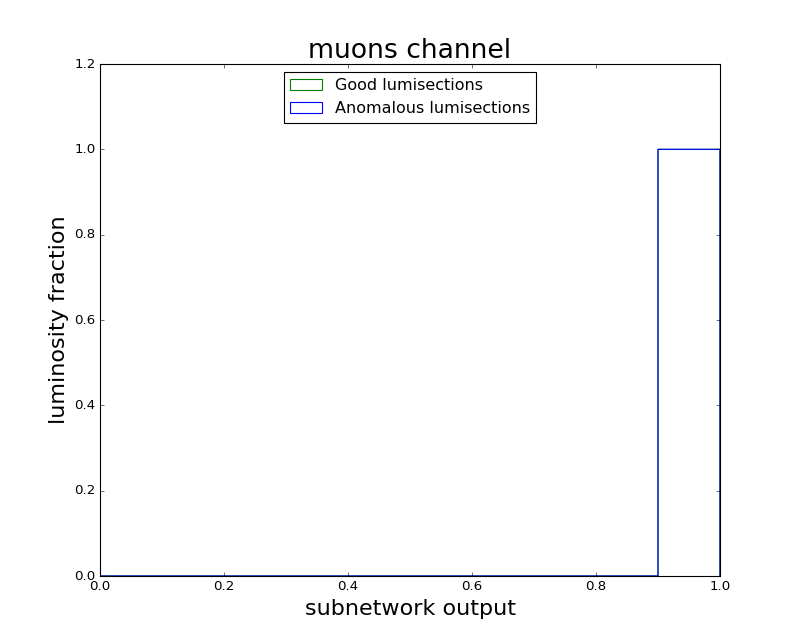

<IPython.core.display.Javascript object>


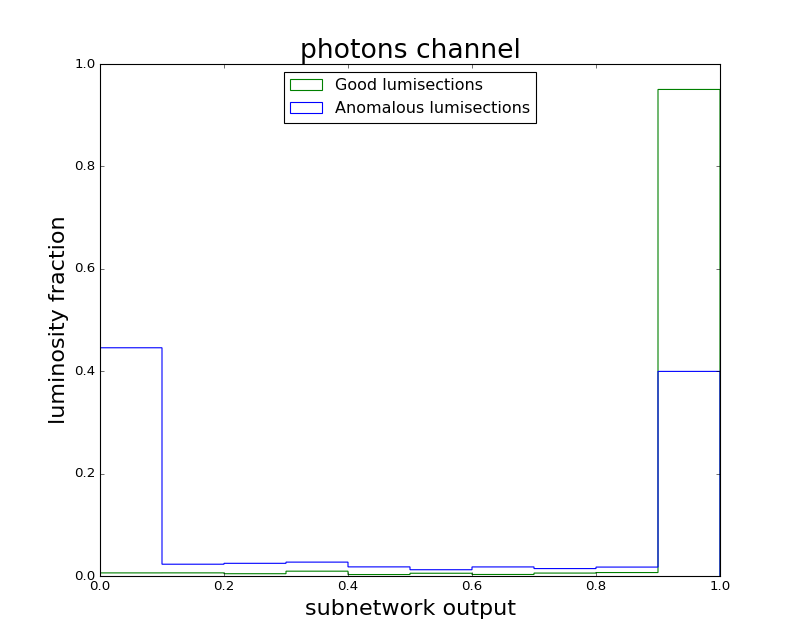

<IPython.core.display.Javascript object>


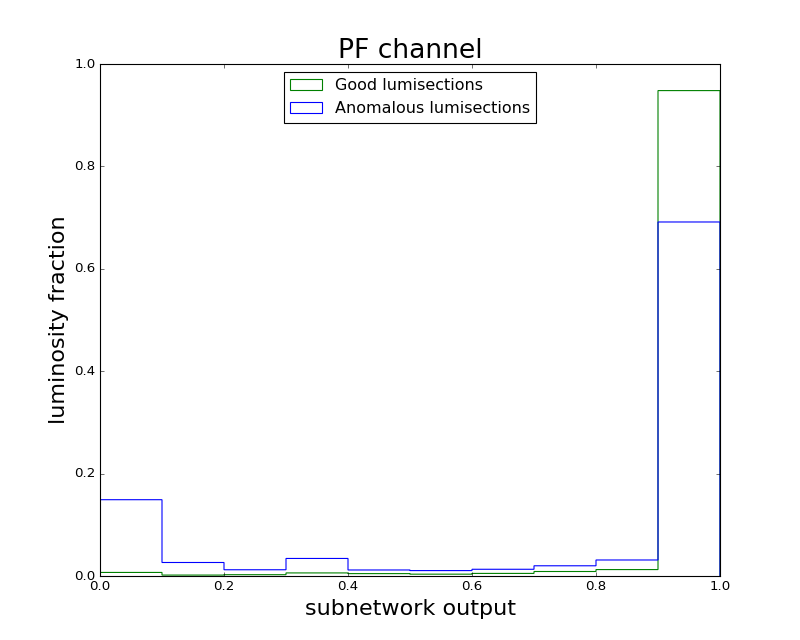

<IPython.core.display.Javascript object>


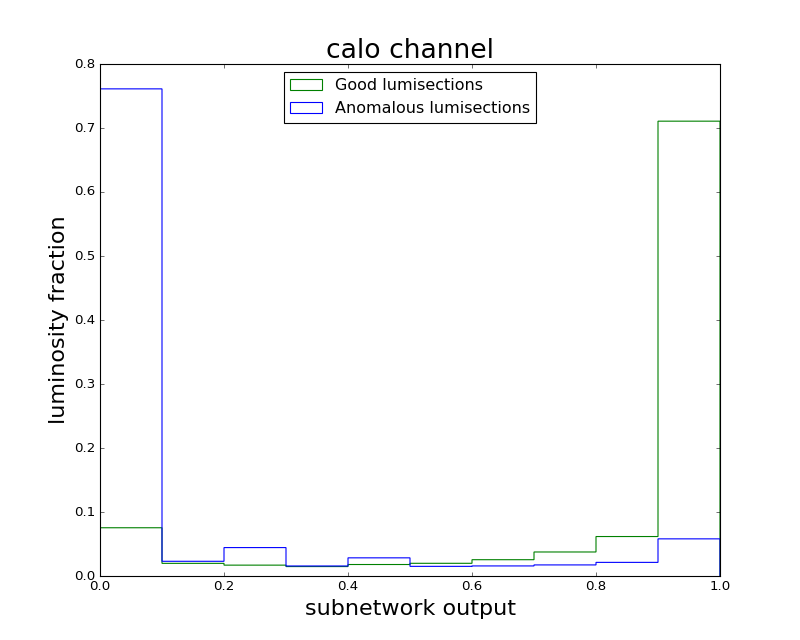

In [66]:
for k in ['muons', 'photons', 'PF', 'calo']:
    proba = probas[k]
    
    plt.figure(figsize=(10, 8))
    plt.hist([
            proba[labels[indx_test] == 0.0],
            proba[labels[indx_test] == 1.0]
    ],bins=10, range=(0, 1), weights=[
        weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
        weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'])
    plt.legend(loc='upper center')
    plt.title('%s channel' % k, fontsize=24)
    plt.ylabel('luminosity fraction', fontsize=20)
    plt.xlabel(r'subnetwork output', fontsize=20)
    plt.show()

In [61]:
photon_net = networks['photons']

<IPython.core.display.Javascript object>


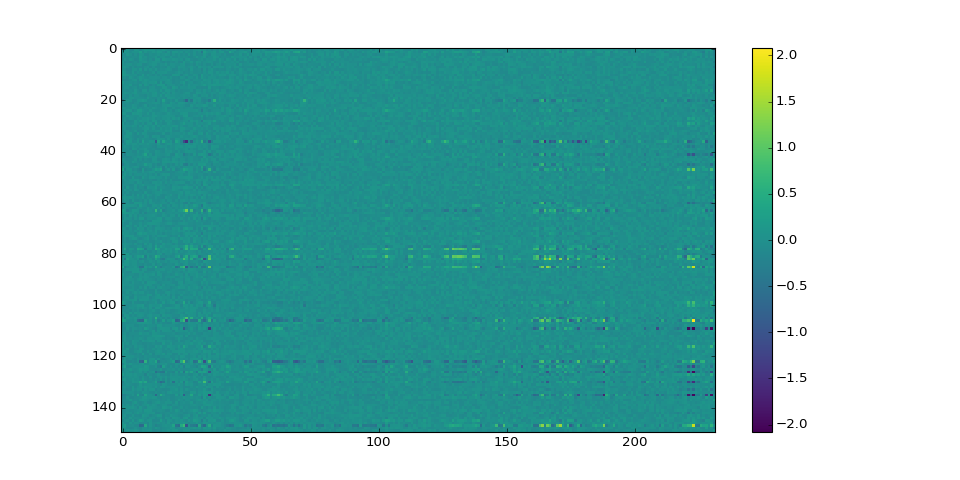

<IPython.core.display.Javascript object>


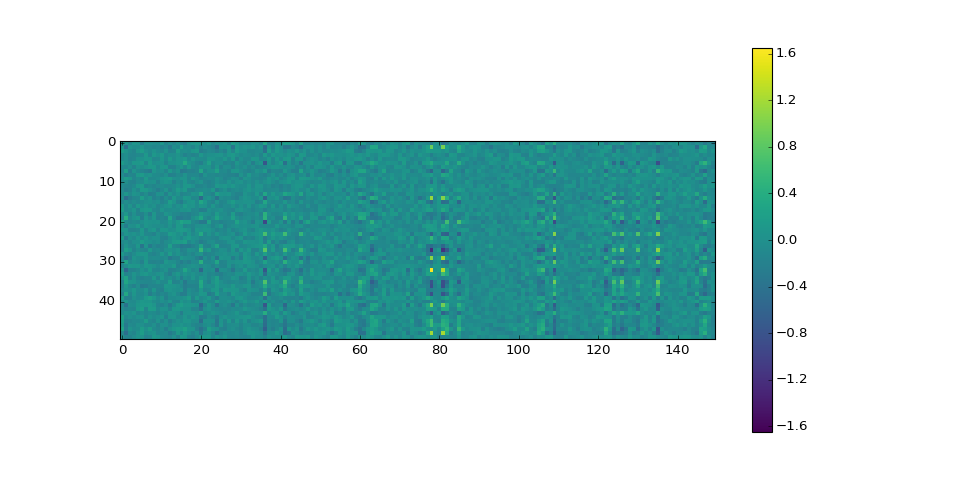

<IPython.core.display.Javascript object>


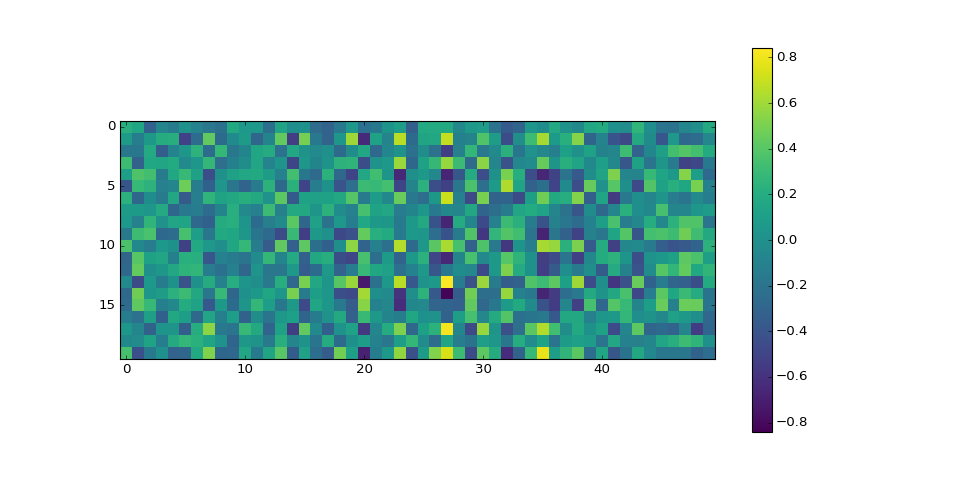

<IPython.core.display.Javascript object>


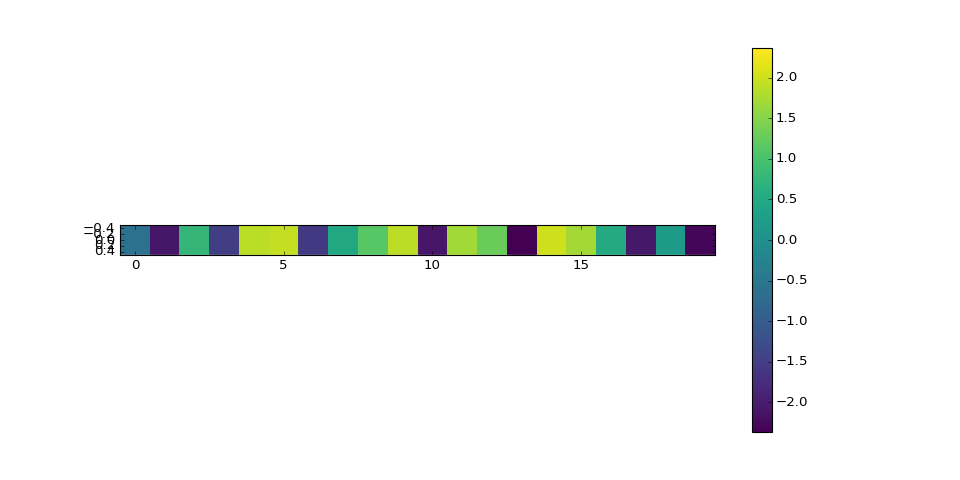

In [67]:
for p in layers.get_all_param_values(photon_net):
    if p.ndim == 2:
        plt.figure(figsize=(12, 6))
        vmin = -np.max(np.abs(p))
        vmax = np.max(np.abs(p))
        plt.imshow(p.T, interpolation='none', cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.show()

In [77]:
channels = ['muons', 'photons', 'PF', 'calo']
sub_systems = sub_labels.columns

aucs = np.ones(shape=(len(channels), len(sub_systems))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems):
        try:
            aucs[i, j] = roc_auc_score(sub_labels[sub_system].iloc[indx_test].get_values(), probas[channel])
        except Exception as e:
            print e

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


<IPython.core.display.Javascript object>


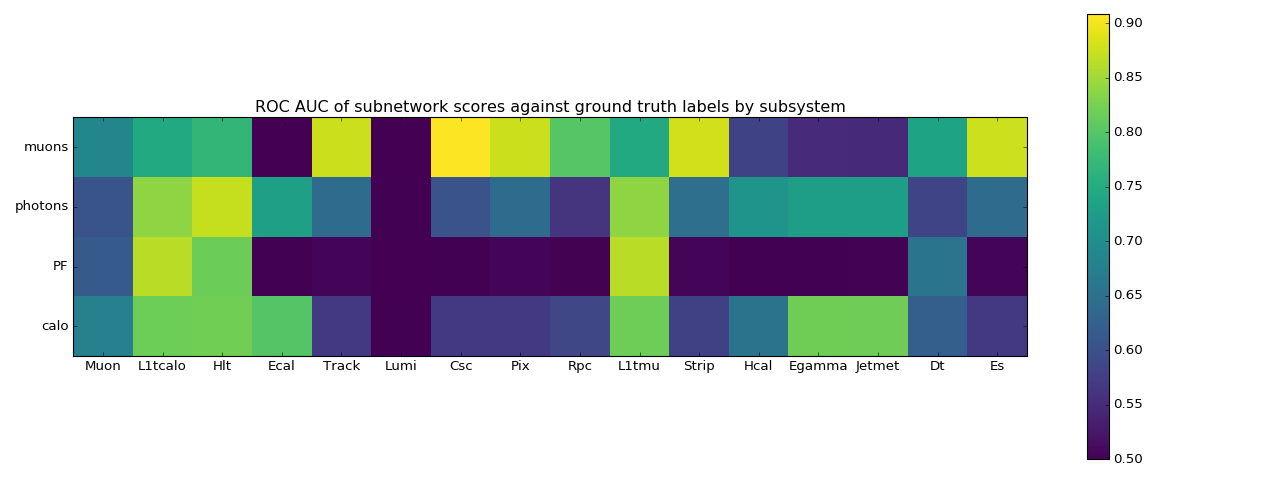

In [100]:
plt.figure(figsize=(16, 6))
plt.imshow(aucs, cmap=plt.cm.viridis, vmin=0.5, interpolation='None', aspect=1)
plt.xticks(np.arange(len(sub_systems)), sub_systems)
plt.yticks(np.arange(4), [ "%s" % g for g in channels ])
plt.colorbar()
plt.title('ROC AUC of subnetwork scores against ground truth labels by subsystem')
plt.show()
plt.tight_layout()

In [89]:
channels = ['muons', 'photons', 'PF', 'calo']
sub_systems = sub_labels.columns

corrs = np.ones(shape=(len(channels), len(sub_systems))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems):
        try:
            a = sub_labels[sub_system].iloc[indx_test].get_values()
            b = probas[channel]
            corrs[i, j] = np.mean((a - np.mean(a)) * (b - np.mean(b))) / np.std(a) / np.std(b)
        except Exception as e:
            print e

<IPython.core.display.Javascript object>


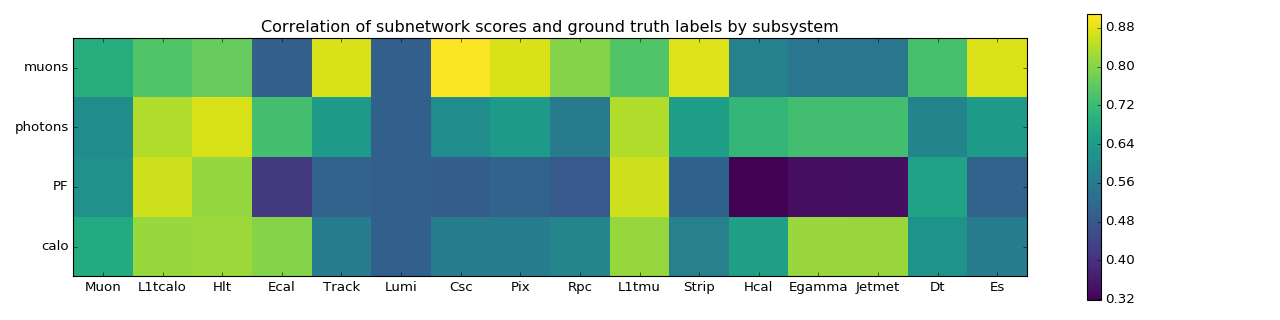

In [101]:
plt.figure(figsize=(16, 4))
plt.imshow(aucs, cmap=plt.cm.viridis, interpolation='None')
plt.xticks(np.arange(len(sub_systems)), sub_systems)
plt.yticks(np.arange(4), [ "%s" % g for g in channels ])
plt.colorbar()
plt.title('Correlation of subnetwork scores and ground truth labels by subsystem')
plt.show()
plt.tight_layout()